In [85]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from MLPKANLayer import MLPKANLayer

In [86]:
# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

In [87]:
# Define MLPKAN
class MLPKAN(nn.Module):
    def __init__(self):
        super(MLPKAN, self).__init__()
        self.MLPkan1 = MLPKANLayer(2, 8, 8, activation=(lambda x: torch.exp(-(x ** 2.0))))
        self.MLPkan2 = MLPKANLayer(8, 16, 4, activation=(lambda x: torch.exp(-(x ** 2.0))))
        self.MLPkan3 = MLPKANLayer(16, 1, 4, activation=(lambda x: torch.exp(-(x ** 2.0))))

    def forward(self, x):
        x = self.MLPkan1(torch.permute(x, (1, 0)))
        x = self.MLPkan2(x)
        x = self.MLPkan3(x)
        return torch.permute(x, (1, 0))

Epoch 1/4500, MLP Loss: 1.5125
Epoch 101/4500, MLP Loss: 0.4480
Epoch 201/4500, MLP Loss: 0.2569
Epoch 301/4500, MLP Loss: 0.1881
Epoch 401/4500, MLP Loss: 0.1726
Epoch 501/4500, MLP Loss: 0.1657
Epoch 601/4500, MLP Loss: 0.1563
Epoch 701/4500, MLP Loss: 0.1498
Epoch 801/4500, MLP Loss: 0.1449
Epoch 901/4500, MLP Loss: 0.1390
Epoch 1001/4500, MLP Loss: 0.1346
Epoch 1101/4500, MLP Loss: 0.1303
Epoch 1201/4500, MLP Loss: 0.1261
Epoch 1301/4500, MLP Loss: 0.1209
Epoch 1401/4500, MLP Loss: 0.1171
Epoch 1501/4500, MLP Loss: 0.1143
Epoch 1601/4500, MLP Loss: 0.1085
Epoch 1701/4500, MLP Loss: 0.1027
Epoch 1801/4500, MLP Loss: 0.0996
Epoch 1901/4500, MLP Loss: 0.0931
Epoch 2001/4500, MLP Loss: 0.0908
Epoch 2101/4500, MLP Loss: 0.0866
Epoch 2201/4500, MLP Loss: 0.0831
Epoch 2301/4500, MLP Loss: 0.0797
Epoch 2401/4500, MLP Loss: 0.0769
Epoch 2501/4500, MLP Loss: 0.0745
Epoch 2601/4500, MLP Loss: 0.0721
Epoch 2701/4500, MLP Loss: 0.0701
Epoch 2801/4500, MLP Loss: 0.0711
Epoch 2901/4500, MLP Loss:

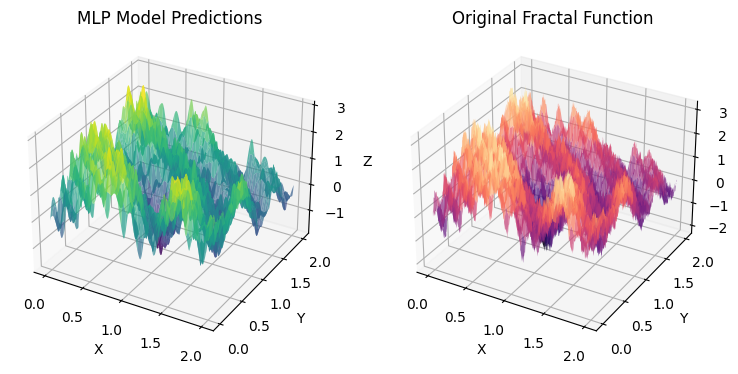

In [88]:
# Set seed and device
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

# Instantiate the models
mlp_model = MLPKAN().to(device)

# Define loss functions and optimizers
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

# Train the models
epochs = 4500
for epoch in range(epochs):
    # MLP Training
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train_2d.to(device))
    loss_mlp = criterion(outputs_mlp, y_train_2d.to(device))
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
mlp_model = mlp_model.to('cpu')
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_mlp = mlp_model(x_test_2d).detach().numpy()

# Plot the results using a 3D plot
fig = plt.figure(figsize=(14, 21))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_test, Y_test, y_pred_mlp.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP Prediction')
ax1.set_title('MLP Model Predictions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax3 = fig.add_subplot(132, projection='3d')
ax3.plot_surface(X_test, Y_test, Z_test, cmap='magma', alpha=0.7, label='Original Function')
ax3.set_title('Original Fractal Function')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

plt.show()

In [89]:
# x_train_2d